In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import least_squares, minimize
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

## Reading and Visualizing Data

### Reading CSV Files

In [2]:
def read_csv ( csv_path ):
    np_path_XYs = np . genfromtxt ( csv_path , delimiter = ',')
    path_XYs = []
    for i in np . unique ( np_path_XYs [: , 0]):
        npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
        XYs = []
        for j in np . unique ( npXYs [: , 0]):
            XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
            XYs . append ( XY )
        path_XYs . append ( XYs )
    return path_XYs

### Visualizing Polylines

In [3]:
def plot ( paths_XYs ):
    fig , ax = plt . subplots ( tight_layout = True , figsize =(8 , 8))
    colours = ['red', 'green', 'blue', 'orange', 'purple']
    for i , XYs in enumerate ( path_XYs ):
        c = colours [ i % len( colours )]
        for XY in XYs :
            ax . plot ( XY [: , 0] , XY [: , 1] , c =c , linewidth =2)
    ax . set_aspect ( 'equal')
    plt . show ()

## Regularizing Curves

### Identifying Straight Lines

In [4]:
def is_straight_line(XY, tolerance=1e-1):
    # Check if all points lie on a single line
    if len(XY) < 2:
        return False
    x1, y1 = XY[0]
    x2, y2 = XY[-1]
    for x, y in XY:
        # Line equation: (y2 - y1)x + (x1 - x2)y + (x2*y1 - x1*y2) = 0
        if abs((y2 - y1) * x + (x1 - x2) * y + (x2 * y1 - x1 * y2)) > tolerance:
            return False
    return True

### Identifying Circles

In [5]:
def calc_R(xc, yc, XY):
    return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)
def f_2(c, XY):
    Ri = calc_R(*c, XY)
    return Ri - Ri.mean()

def fit_circle(XY):
    center_estimate = XY.mean(axis=0)
    result = minimize(lambda c: np.sum(f_2(c, XY)**2), center_estimate, method='L-BFGS-B')
    return result.x

def is_circle(XY, tolerance=0.01):
    xc, yc = fit_circle(XY)
    Ri = calc_R(xc, yc, XY)
    R = Ri.mean()
    residuals = np.abs(Ri - R)
    return np.all(residuals < tolerance)

### Identifying Ellipses

In [6]:
def fit_ellipse(XY):
    x = XY[:, 0]
    y = XY[:, 1]
    x_mean = x.mean()
    y_mean = y.mean()
    x = x - x_mean
    y = y - y_mean
    D = np.column_stack((x**2, x*y, y**2, x, y, np.ones_like(x)))
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    _, _, V = np.linalg.svd(np.dot(np.linalg.inv(S), C))
    a = V[0, :]
    return a, x_mean, y_mean

def is_ellipse(XY):
    a, x_mean, y_mean = fit_ellipse(XY)
    if a[1]**2 - 4 * a[0] * a[2] < 0:
        return True
    return False

### Identifying Rectangles

In [7]:
def is_rectangle(points, tolerance=1e-2):
    if len(points) < 4:
        return False
    
    # Perform KMeans clustering to identify four corner clusters
    kmeans = KMeans(n_clusters=4).fit(points)
    cluster_centers = kmeans.cluster_centers_

    # Calculate the convex hull to ensure the points form a rectangle
    hull = ConvexHull(cluster_centers)
    
    # Check if the hull has four vertices
    if len(hull.vertices) != 4:
        return False

    # Get the vertices of the convex hull in order
    hull_points = cluster_centers[hull.vertices]

    def distance(p1, p2):
        return np.linalg.norm(p1 - p2)

    def angle(p1, p2, p3):
        v1 = p1 - p2
        v2 = p3 - p2
        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        return np.degrees(angle)
    
    # Check if the hull points form a rectangle
    d = [distance(hull_points[i], hull_points[(i + 1) % 4]) for i in range(4)]
    angles = [angle(hull_points[i], hull_points[(i + 1) % 4], hull_points[(i + 2) % 4]) for i in range(4)]
    
    if (abs(d[0] - d[2]) < tolerance and abs(d[1] - d[3]) < tolerance and
        all(abs(a - 90) < tolerance for a in angles)):
        return True
    
    return False

### Identifying Rounded Rectangles

In [8]:
def is_rounded_rectangle(XY):
    if len(XY) < 8:  # A rounded rectangle must have at least 8 points (4 straight segments and 4 arcs)
        return False
    
    def check_straight_segment(p1, p2, threshold=1e-2):
        line_vec = p2 - p1
        for p in XY:
            if not np.allclose(np.cross(line_vec, p - p1), 0, atol=threshold):
                return False
        return True
    
    def check_arc(p1, p2, p3, threshold=1e-2):
        mid_point = (p1 + p3) / 2
        radius = np.linalg.norm(p1 - mid_point)
        for p in XY:
            if not np.isclose(np.linalg.norm(p - mid_point), radius, atol=threshold):
                return False
        return True
    
    # Divide points into segments and check
    n = len(XY) // 4
    for i in range(4):
        if not check_straight_segment(XY[i*n], XY[(i*n + n//2) % len(XY)]) or \
           not check_arc(XY[(i*n + n//2) % len(XY)], XY[(i*n + n) % len(XY)], XY[(i*n + n*3//2) % len(XY)]):
            return False
    return True

### Regularize Curves

In [9]:
def regularize_curve(XY):
    if is_straight_line(XY):
        print("Straight line found")
        return np.array([XY[0], XY[-1]])
    elif is_circle(XY):
        print("Circle found")
        center = np.mean(XY, axis=0)
        radius = np.mean(np.linalg.norm(XY - center, axis=1))
        t = np.linspace(0, 2 * np.pi, len(XY))
        return np.vstack((center[0] + radius * np.cos(t), center[1] + radius * np.sin(t))).T
    # elif is_ellipse(XY):
    #     print("Ellipse found")
    #     center = np.mean(XY, axis=0)
    #     radii = np.linalg.norm(XY - center, axis=1)
    #     a, b = np.max(radii), np.min(radii)
    #     t = np.linspace(0, 2 * np.pi, len(XY))
    #     return np.vstack((center[0] + a * np.cos(t), center[1] + b * np.sin(t))).T
    elif is_rectangle(XY):
        print("Rectangle found")
        return XY
    elif is_rounded_rectangle(XY):
        print("Rounded rectangle found")
        return XY
    else:
        print("No regular shape found")
        return XY

def regularize(path_XYs):
    regularized_paths = []
    for path in path_XYs:
        regularized_path = []
        for XY in path:
            regularized_path.append(regularize_curve(XY))
        regularized_paths.append(regularized_path)
    return regularized_paths

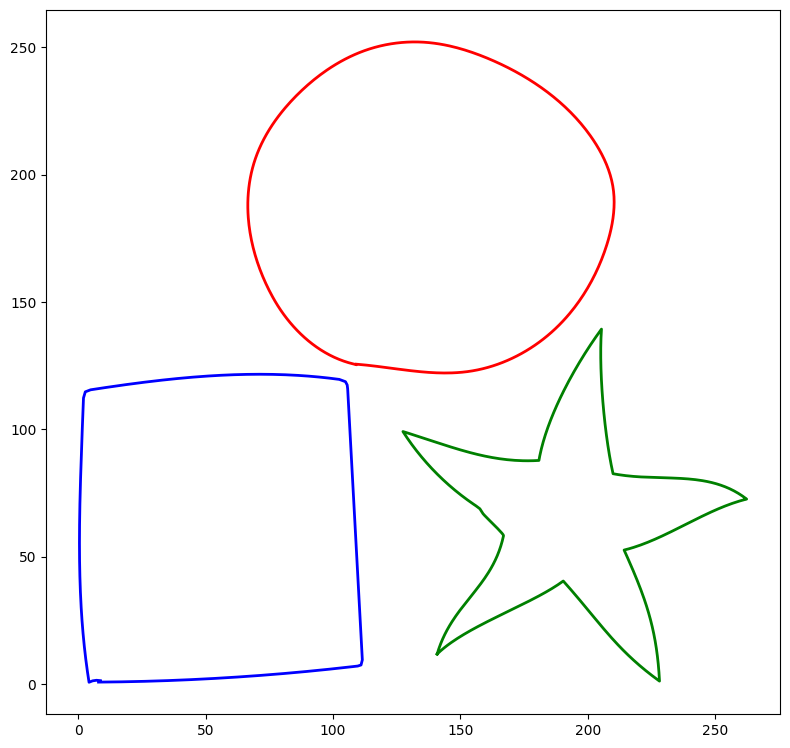

No regular shape found
No regular shape found
No regular shape found


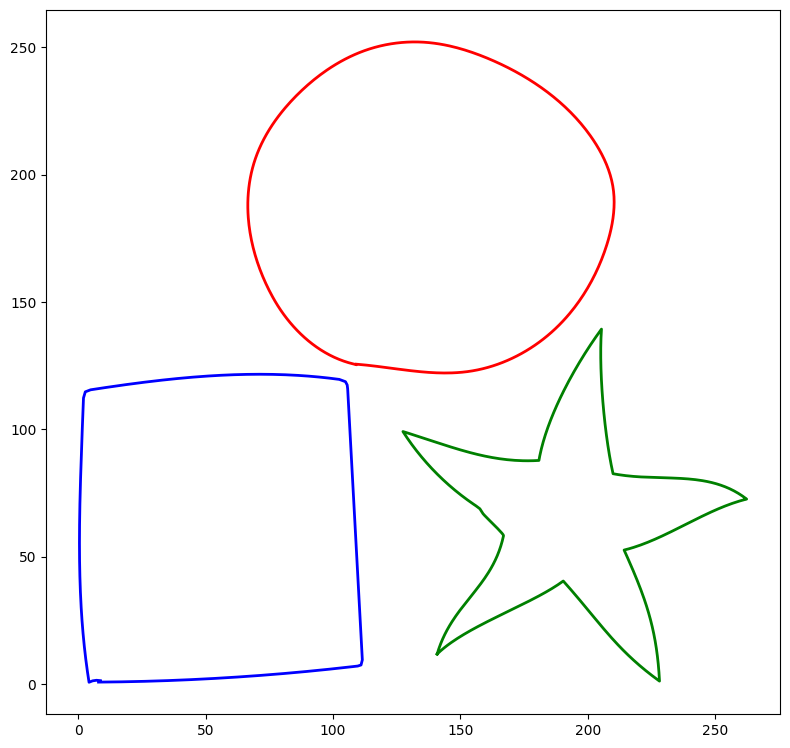

In [10]:
CWD = os.getcwd()
csv_name = 'problems/isolated.csv'
csv_path = os.path.join(CWD, csv_name)
path_XYs = read_csv(csv_path)
plot(path_XYs)
regularized_paths = regularize(path_XYs)
plot(regularized_paths)

In [11]:
path_XYs[1]

[array([[140.84300232,  11.85200024],
        [141.45674133,  12.43616676],
        [142.09480286,  13.01455879],
        ...,
        [141.49961853,  13.91237926],
        [141.1630249 ,  12.89239883],
        [140.84399414,  11.84700012]])]

## Exploring Symmetry

### Reflection Symmetry

In [4]:
def reflection_symmetry(points, tolerance=1e-3):
    for i in range(len(points)):
        if np.allclose(points, np.roll(points[::-1], i, axis=0), atol=tolerance):
            return True
    return False

## Completing Incomplete Curves

### Completing a Disconnected Circle

In [5]:
def complete_circle(points, gap_points):
    from scipy.spatial import ConvexHull
    hull = ConvexHull(np.vstack([points, gap_points]))
    return hull.points[hull.vertices]

## Visualization and Export

### Converting Polylines to SVG

In [6]:
import svgwrite
import cairosvg

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = 'black'
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H,
                     output_width=max(1, 1024 // min(H, W)) * W, output_height=max(1, 1024 // min(H, W)) * H,
                     background_color='white')

    return

OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: 'libcairo.so.2' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache), 'libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.so.2'
cannot load library 'libcairo.2.dylib': dlopen(libcairo.2.dylib, 0x0002): tried: 'libcairo.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file, not in dyld cache), 'libcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file, not in dyld cache).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.2.dylib'
cannot load library 'libcairo-2.dll': dlopen(libcairo-2.dll, 0x0002): tried: 'libcairo-2.dll' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file, not in dyld cache), 'libcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file, not in dyld cache).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo-2.dll'